# ALL THE APPLES

#### Why apples?

I eat an apple almost every day. Not to keep up with any proverb about doctors, but because I just really like apples. I enjoy crunching into a crisp, fresh apple with my lunch. This means I probably eat over 300 apples a year assuming I eat 6/wk. That totals close to 100 pounds of apples a year. That's a lot of apple (and doesn't even take into count when I use them to bake even tastier things).

I particularly like apples for several reasons. First, I have a sweet tooth, so I gravitate naturally towards sweet fruit snacks to fend off cravings for, well... significantly less healthy temptations. But in addition, apples seem to have less variation in price over the course of the year. I can count on apples to be a consistent fraction of my grocery expenditures from week to week. I like consistency.

This is partly due to their ease of storage; other fruits like berries can be notoriously difficult to keep fresh while it is not their growing season, but apples are less affected by this. Additonally, apples have a fairly long growing season across the United States, whose in-season geographic coverage moves slowly southward as the months go. And besides, apple-picking is the best.

While I chomped through yet another apple recently, I wondered about the fluctuations, or lack thereof, in their price and availability (especially as it's the thick of winter and I have continued to see 99 cents/pounds signs occasionally at the local grocer). So I decided to look into it and here you are - an analysis of monthly apples prices from 1980 to 2010.

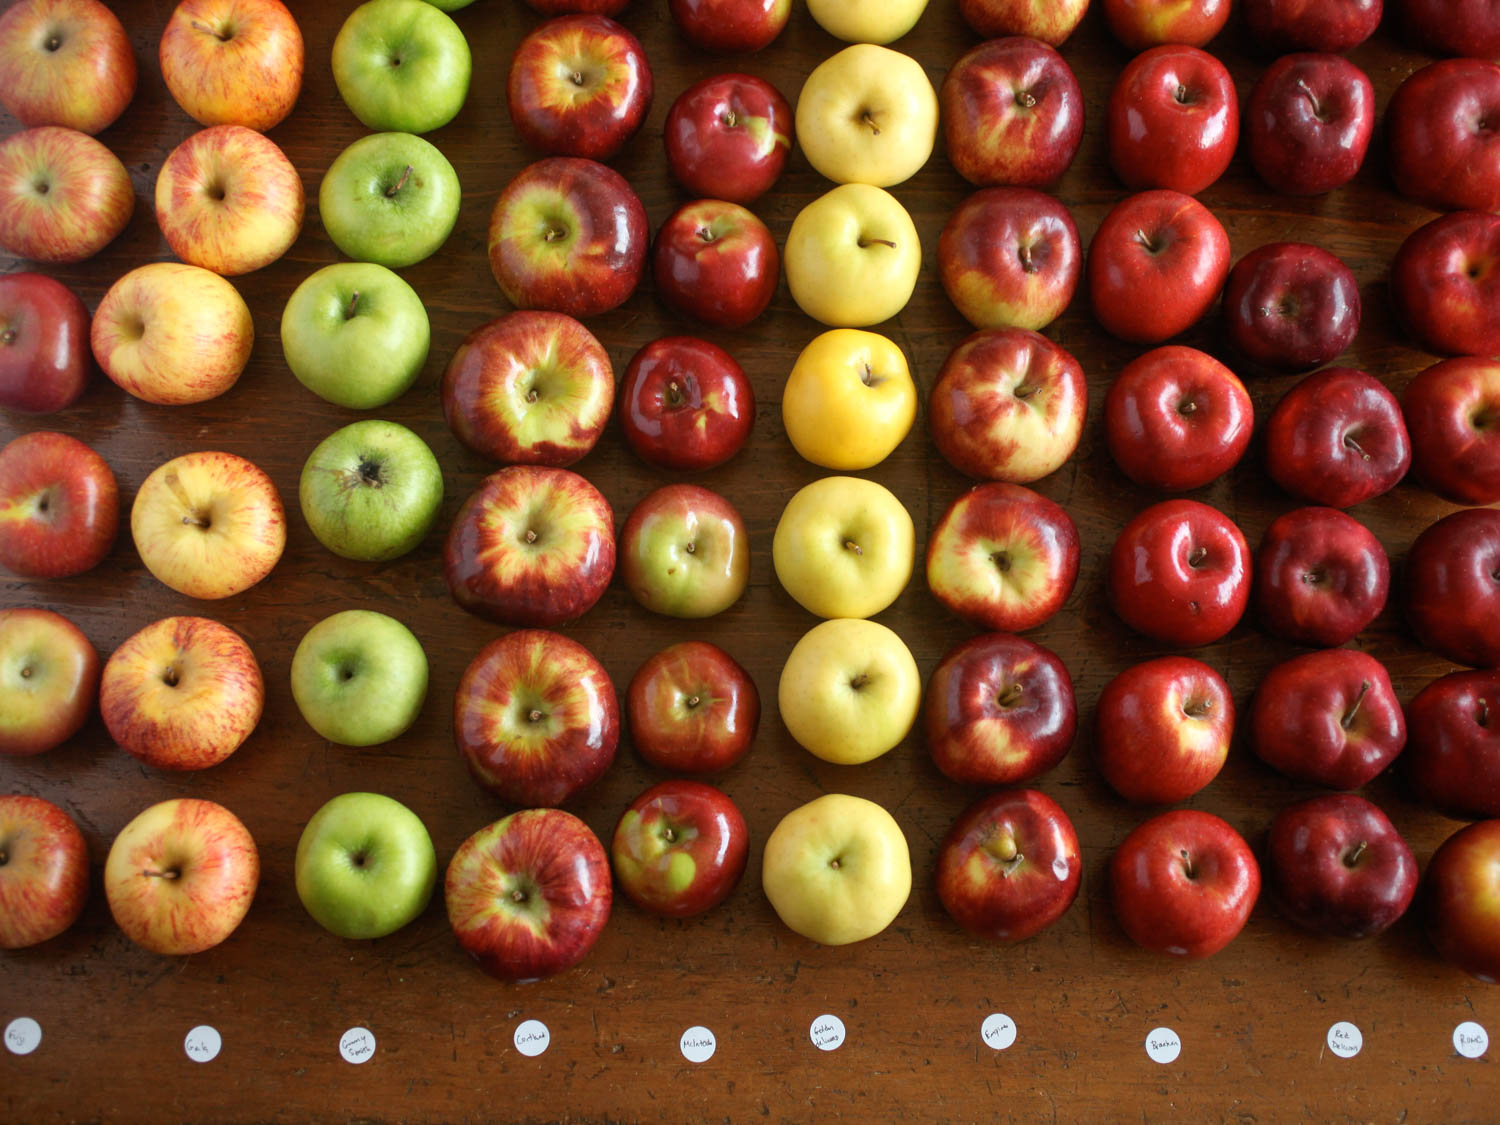

In [1]:
from IPython.display import Image
Image(filename="ApplePic.jpeg")

### 1. Load in necessary packages

In [2]:
%matplotlib inline
import scipy
from pylab import *
from matplotlib import *
import numpy as np
import scipy
import re
import pandas as pd
from pandas import datetime
from pandas.tools.plotting import autocorrelation_plot
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn import preprocessing as pre

rcdefaults()
rc('font',family='Bitstream Vera Serif')

### 2. Load in data and prep/clean

These data come from the United States Department of Agriculture (USDA) Economic Research Institute (specifically, tables 20 through 24 - http://usda.mannlib.cornell.edu/MannUsda/viewDocumentInfo.do?documentID=1825). These tables hold month-to-month averages of apple prices and available stock, as detailed below by their referred names in this notebook:
- 'Fresh Price' --> the overall price of fresh apples, as paid to growers
- 'Red Price' --> the monthly retail prices of fresh Red Delicious apples
- 'Fresh apples' --> Monthly stocks in cold storage
- 'Frozen apples' --> Monthly stocks in cold storage

First, we load and clean up these data tables, combining them all together in long form by date.

In [3]:
### Define a function to load in each table
def load_clean(i):
    tab = pd.read_excel('table2'+str(i)+'.xls', skiprows=1, skip_footer=2, na_values=['--','     N.A.'])  # the table has unusual demarcation of Nan values
    df = pd.DataFrame(tab)    ### set up dataframe
    df = df.dropna()          ### remove non-existent data
    df.columns = [i.strip() for i in df.columns]  ### this will help standardize column headings, some of which have weird spacings in the tables
    pattern = re.compile(r'\s+')                                   ### as above, removing whitespace
    df.columns = [re.sub(pattern, '', lab) for lab in df.columns]  ### as above, removing whitespace
    ###### Now, we re-make the table into a long form by year and month
    df = pd.melt(df, id_vars = ["Year"], value_vars = [u'Jan.', u'Feb.', u'Mar.', u'Apr.', u'May.', u'June', u'July',
                                                       u'Aug.', u'Sep.', u'Oct.', u'Nov.', u'Dec.'])
    return df

In [4]:
#### Load first table
FullTable = load_clean(0)
#### Load other tables and combine by year and month
for i in range(1,4):
    df = load_clean(i)
    FullTable = FullTable.merge(df, on=['Year','variable'], how='inner')
    
months = {'Apr.': 4, 'Aug.': 8, 'Dec.': 12, 'Feb.': 2, 'Jan.': 1, 'July': 7, 'June': 6, 'Mar.': 3, 'May.': 5, 'Nov.': 11, 'Oct.': 10, 'Sep.': 9}
FullTable['month_number'] = FullTable['variable'].map(months)              #### assign a "month" numeric for secondary sorting
FullTable = pd.DataFrame(FullTable.sort(['Year','month_number']))          #### sort by year and then by month number
FullTable = FullTable.reset_index(drop=True)                               #### reset the index after sort for easier access
FullTable = FullTable.apply(lambda x:x.fillna(x.value_counts().index[0]))  #### imputing for NAs that may remain
FullTable.columns = ['Year', 'Month', 'freshprice', 'redprice', 'freshstock', 'frozenstock','MonthNum']
FullTable[0:5]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Year,Month,freshprice,redprice,freshstock,frozenstock,MonthNum
0,1980.0,Jan.,0.141,0.554,2226.463,83.908,1
1,1980.0,Feb.,0.149,0.574,1597.172,86.812,2
2,1980.0,Mar.,0.166,0.593,1046.602,81.099,3
3,1980.0,Apr.,0.170,0.634,651.180,68.875,4
4,1980.0,May.,0.179,0.974,3332.901,78.661,5


In [5]:
#### Alternatively, we can also just put month and year together -- this will make plotting wrt time easier
def parser(X,Y):
    return [datetime.strptime(str(int(x))+'-'+str(y), '%Y-%m') for x,y in zip(X,Y)]
FullTable['dates'] = parser(FullTable['Year'], FullTable['MonthNum'])
print FullTable['dates'][0:5]

0   1980-01-01
1   1980-02-01
2   1980-03-01
3   1980-04-01
4   1980-05-01
Name: dates, dtype: datetime64[ns]


### 3. An initial exploratory analysis

Let's check out what these data look like on the surface!

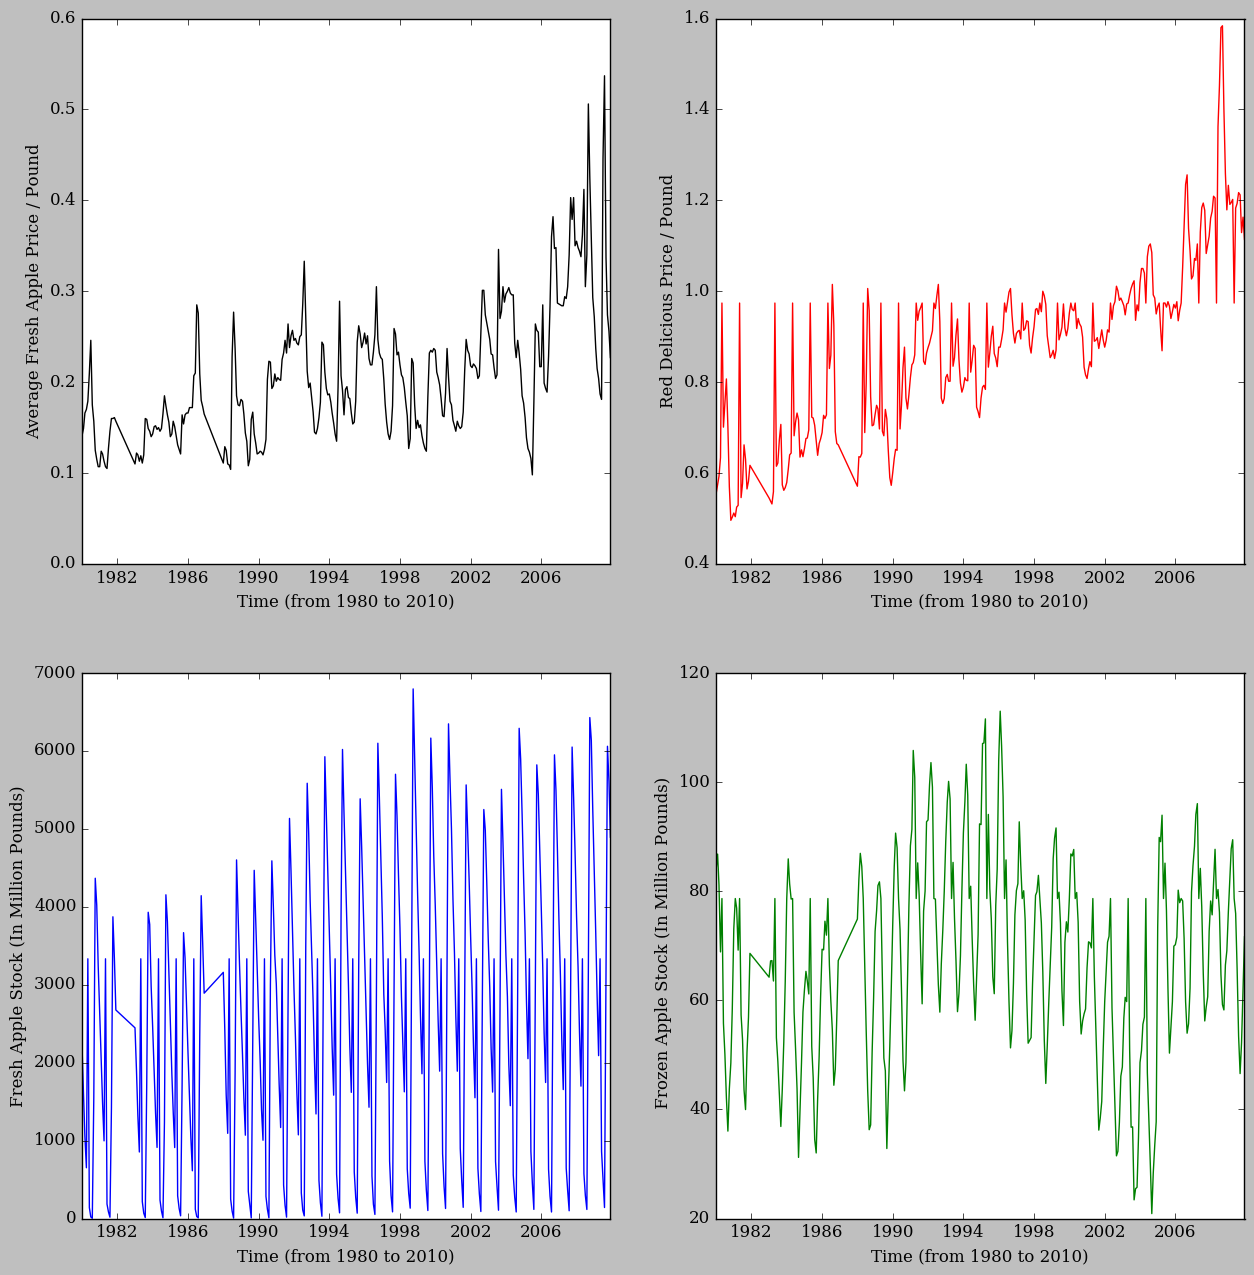

In [6]:
#### Starting with a simple multi-panel line plot
f, ((ax,bx),(cx,dx)) = plt.subplots(2,2, figsize=(15,15))
cols = ['black', 'red', 'blue', 'green']
vals = ['freshprice', 'redprice', 'freshstock', 'frozenstock']
labels = ['Average Fresh Apple Price / Pound', 'Red Delicious Price / Pound', 
          'Fresh Apple Stock (In Million Pounds)', ' Frozen Apple Stock (In Million Pounds)']
for i, axs in enumerate([ax,bx,cx,dx]):
    axs.plot(FullTable['dates'], FullTable[vals[i]], ls='-', color=cols[i])
    axs.set_ylabel(labels[i]); axs.set_xlabel('Time (from 1980 to 2010)')
plt.show()

The seasonal variation is exceedingly clear, particularly in the stock of fresh apples, but certainly in the frozen stock as well. The overall fresh apple prices (and those specifically of red delicious apples) follow a generally similar trend, with the seasonal variation much less extreme than in the apple stock.

The overall apple prices seem to slowly climb over time, suggesting a slight non-stationary trend to the prices; this is likely due in large part to inflation. However, the red delicious do appear to show a greater uptick in prices in recent years than the overall prices of apples.

Additionally, the peaks of the fresh apple stock over time reaches higher and higher peaks (that would be in September, see below). As the (overall) U.S. population continues to grow with each year, the increase in apples in stock storage logically also increases. This trend can be seen in the max stock level per year (unanimously September) as well as in the minimum storage numbers per year (in April each year).

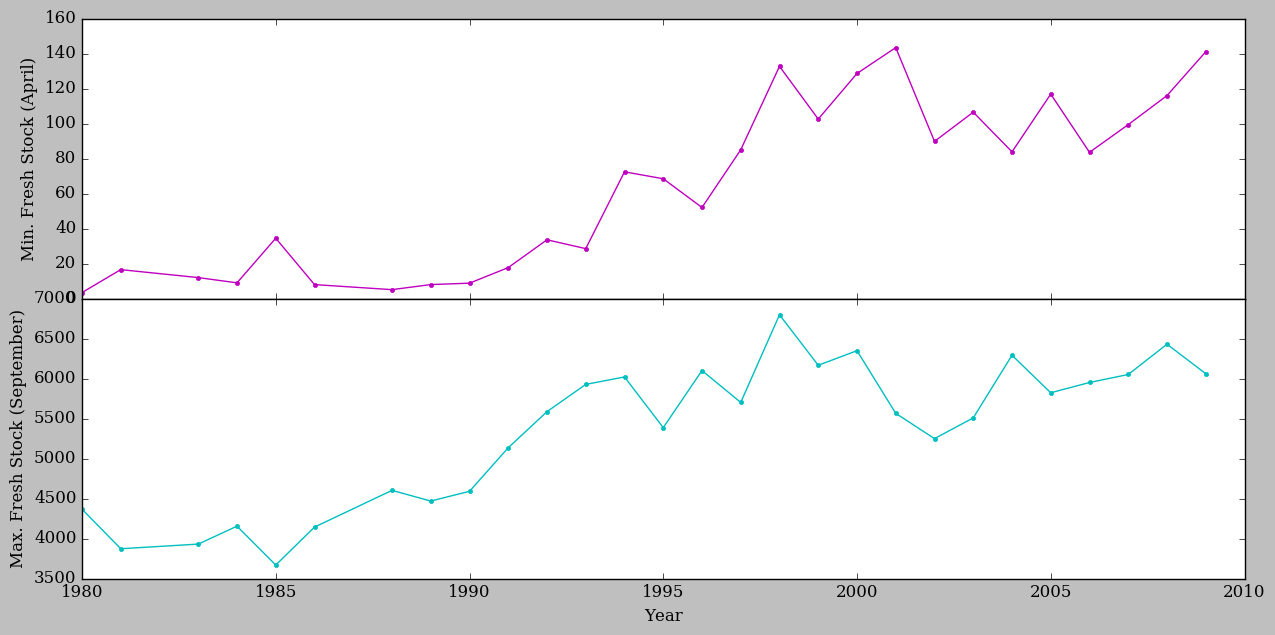

In [7]:
f, ((ax,bx)) = plt.subplots(2,1, figsize=(15,7)); subplots_adjust(hspace=0); ax.set_xticklabels('')
min_stocks = array([min(FullTable['freshstock'][(FullTable['Year']==i)]) for i in unique(FullTable['Year'])])
max_stocks = array([max(FullTable['freshstock'][(FullTable['Year']==i)]) for i in unique(FullTable['Year'])])
ax.plot(unique(FullTable['Year']), min_stocks, 'm.', ls='-')#, min(FullTable['Month'][(FullTable['Year']==i)]), 
bx.plot(unique(FullTable['Year']), max_stocks, 'c.', ls='-' )#, max(FullTable['Month'][(FullTable['Year']==i)])
ax.set_ylabel('Min. Fresh Stock (April)'); bx.set_ylabel('Max. Fresh Stock (September)'); bx.set_xlabel('Year')
plt.show()

Presumably this reflects the greater demand of apples from a larger population over time. I decided to check this with some US populations data (https://www.cia.gov/library/publications/the-world-factbook/geos/us.html).

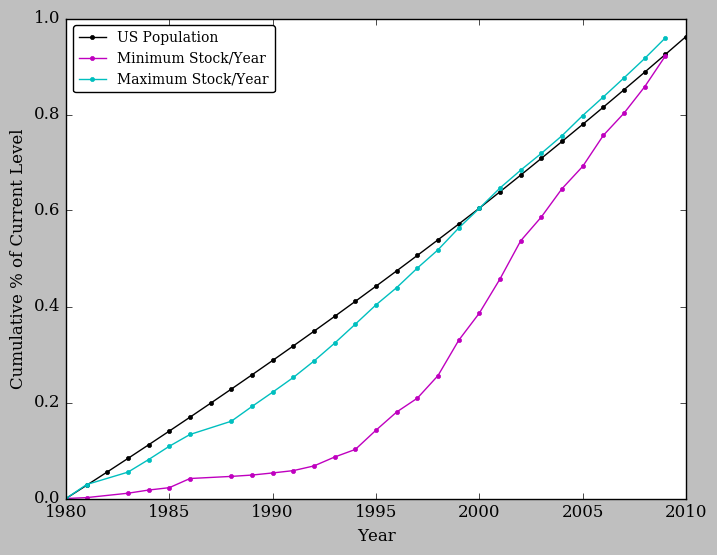

In [8]:
Years, Pops = loadtxt('USpop.txt', unpack=True)
plot(Years, [sum(Pops[:i])/sum(Pops) for i in range(0,len(Pops))], 'k.', ls='-', label='US Population')
plot(unique(FullTable['Year']), [sum(min_stocks[:i])/sum(min_stocks) for i in range(0,len(min_stocks))], 'm.', ls='-', label='Minimum Stock/Year') 
plot(unique(FullTable['Year']), [sum(max_stocks[:i])/sum(max_stocks) for i in range(0,len(max_stocks))], 'c.', ls='-', label='Maximum Stock/Year')
plt.legend(fancybox=True, loc=2, numpoints=1, prop={'size':10})
ylabel('Cumulative % of Current Level'); xlabel('Year')
plt.show()

The minimum stock in storage appears to lag behind the population, but the maximum stocks tracks quite well with the increase in population. This would suggest that the industry has adapted to the increase in population/demand by increasing the apples in fresh stock.

### 4. ARIMA Prediction Model

Now, on to an analysis of prices.

To model the historic data to predict how the price will change, I first implement an ARIMA model (Auto-Regressive Integrated Moving Average). This is a 1-D model; as in, it only depends on the history of the fresh apple prices and does not include other exogenous parameters.

The main inputs of the ARIMA model are p, d, and q - the number of lagged observations, the degree to which the raw observations are differenced with each other, and the window used for the moving average.

I estimated the initial value of p by examining the auto-correlation plot of the overall fresh apple prices (below, the seasonality is quite evidence). The autocorrelation is positive during the initial 20-25 lags or so, but not significant beyond maybe ~5 or 10 lags (the green dotted line indicates 5 lags, which we use for an inital starting point for p).

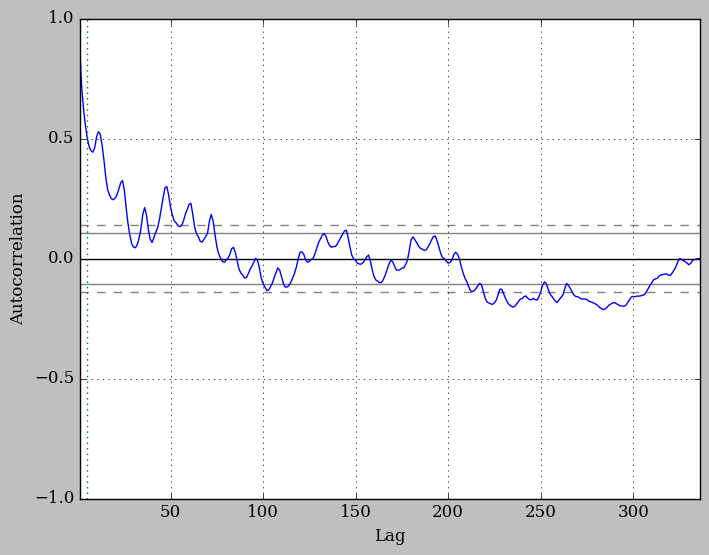

In [9]:
autocorrelation_plot(FullTable['freshprice'])
axvline(5, color='green', ls=':')
plt.show()

We choose d = 1 to stationarize the data and a moving box average (q) of 0. This sets up our basic ARIMA model.

Now, we split the data into a training and test set:

In [10]:
size = int(len(np.asarray(FullTable['freshprice'])) * 0.8)  ### size of training set (268 observations)
train = np.asarray(FullTable['freshprice'])[0:size]
test = np.asarray(FullTable['freshprice'])[size:len(np.asarray(FullTable['freshprice']))]

Now that there is a 80-20 split train and test set, I can implement the ARIMA model, which I invoke as a rolling model, forcasting each next step based on the entire history of the prices up to that point.

#### Case 1
First, the history is initialized as the training set (The first 80% of the data). At each iteration, I use the history of the chain to predict the next step. In this first case, I append the history of prices at each step with the true observed value at that point, and re-model the entire set of prices during the next step:

In [11]:
hist = list(train)     #### history begins with 
preds1 = []             #### create prediction list 
for t in range(len(test)):
    model = ARIMA(hist, order=(5,1,0))  ### make the model on the training set
    model_fit1 = model.fit(disp=0)
    preds1.append(model_fit1.forecast()[0])  ### forecast the next step
    hist.append(test[t])                   ### add the next step to the chain
preds1 = array(preds1)[:,0]
error = 1.-mean_squared_error(test, preds1)
print('Accuracy: %.7f' % error)

Accuracy: 0.9967062


Of course, building the model step by step, we expect good results, so a 99.7% accuracy is not surprising. We examine the residuals as well, which appear strongly peaked, Gaussian, and without major mean offset:

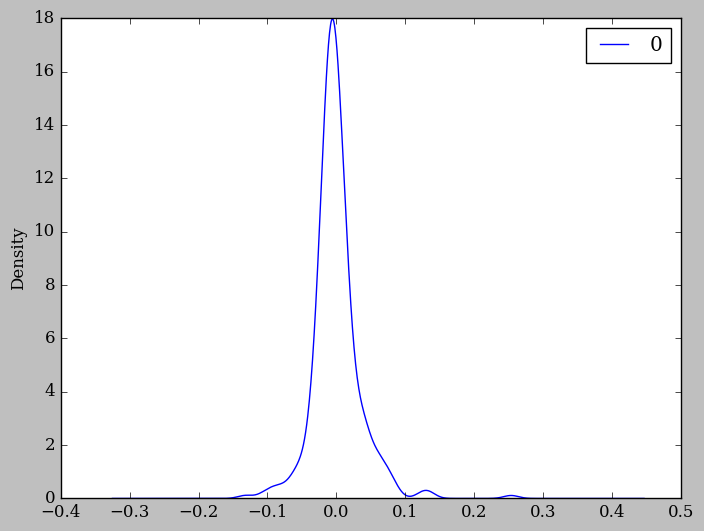

,0
count,334.000000
mean,0.000047
std,0.034314
min,-0.132055
25%,-0.015247
50%,-0.003903
75%,0.011062
max,0.253764


In [12]:
resids1 = pd.DataFrame(model_fit1.resid)
resids1.plot(kind='kde')
plt.show()
resids1.describe()

#### Case 2
Now, I repeat the same process - except! This time rather than building on the history chain with the *true* observed value from the test set, I substitute the *predicted* value instead to build on the history with predictions. As in - how far ahead can we predict well?

In [13]:
hist = list(train)     #### history begins with training set
preds2 = []             #### create prediction list 
for t in range(len(test)):
    model = ARIMA(hist, order=(5,1,0))  ### make the model on the training set
    model_fit2 = model.fit(disp=0)
    preds2.append(model_fit2.forecast()[0])  ### forecast the next step
    hist.append(model_fit2.forecast()[0])    ### add predicted step to the chain 
preds2 = array(preds2)[:,0]
error = 1.-mean_squared_error(test, preds2)
print('Out-of-sample accuracy: %.7f' % error)

Out-of-sample accuracy: 0.9913735


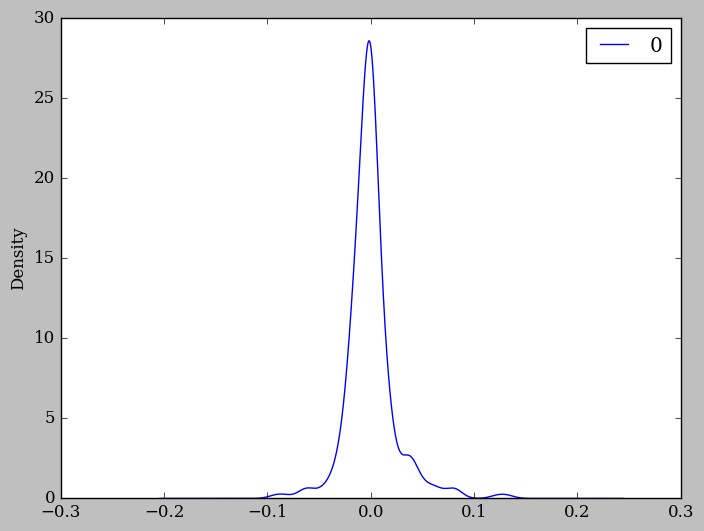

,0
count,3.340000e+02
mean,3.504821e-05
std,2.343827e-02
min,-9.217604e-02
25%,-1.045537e-02
50%,4.491461e-09
75%,3.671684e-03
max,1.320579e-01


In [14]:
resids2 = pd.DataFrame(model_fit2.resid)
resids2.plot(kind='kde')
plt.show()
resids2.describe()

The accuracy suffers slightly compared to building on the true observations in the first case; if taken at face value, appears rather good for reaching 20% further out than the original range of data (~67 days). We would expect the accuracy to drop off as we predict (and build on predictions) further and further from the known data.

HOWEVER, in examining the plot of the predictions with the true values, it's easy to tell that we are only tracking the mean changes. **Accuracy is not everything!** This should be obvious, but we clearly need consistenly updated observations to keep the ARIMA model going if we want it to have any useful predictive power.

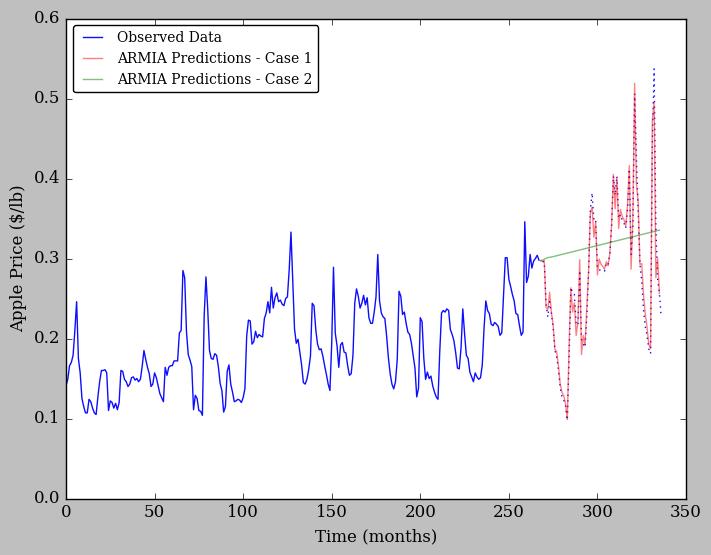

In [15]:
#### Visualizing the results
pyplot.plot(train, color='blue', label='Observed Data', alpha=0.95)
pyplot.plot(arange(0,len(test))+len(train)+1, test, color='blue', ls=':', alpha=0.95)
pyplot.plot(arange(0,len(test))+len(train), preds1, color='red', label='ARMIA Predictions - Case 1', alpha=0.5)
pyplot.plot(arange(0,len(test))+len(train), preds2, color='green', label='ARMIA Predictions - Case 2', alpha=0.5)
plt.legend(fancybox=True, loc=2, prop={'size':10})
xlabel('Time (months)');ylabel('Apple Price ($/lb)') ### prices received by growers 
pyplot.show()

### 5. SVR Prediction Model

With a Supprt Vector Regression model, we can take into account more variables than in the ARIMA model above. This is a useful approach, for the obvious reason of being able to incorporate additional, potentially informative features. However, it is further useful in that we can choose an SVR model to project the features to a higher order of dimensions - which is great for the case in which we have interdependencies in our features which can be more finely modeled.

#### Case 1: A simple model

We start with a simple "1-D" model - price and time - as in the ARIMA analysis. Then, more features are included. For this first case, like in the ARIMA model, time lags are used to address the time-dependent nature of the prices -- the next price in time is not independent of the current price in time.

Here, we also regularize the data by putting the chosen features on a similar scale (by subtracting the mean and dividing by the standard deviation). This will avoid a skewing of the model to fit some features more than others.

We devide 80-20 into train and test sets, as before, fitting the first 80% of the temporal data with the SVR model and using the most recent 20% of data to test the predictions from the model.

In [38]:
def create_lags(df, N):
    ### this is from http://stackoverflow.com/questions/41311017/time-series-forecasting-with-svr-in-scikit-learn?rq=1
    ### and I do not claim credit
    for i in range(N):
        df['Lag' + str(i+1)] = df.freshprice.shift(i+1)
    return df

nlags = 15

subset = FullTable[['dates', 'freshprice']]
subset = create_lags(subset,15)      ### create N lags
subset = subset.dropna()             ### because we created N lags, the first N rows are now nan's

y = subset.freshprice.values         ### values to predict
X = subset.iloc[:, 1:].values        ### features used in prediction
size = int(len(subset) * .8)         ### 

trainX = X[:size]; trainy = y[:size] ### create 80% training set
testX =  X[size:]; testy = y[size:]  ### create 20% testing set

scaler = pre.StandardScaler().fit(trainX)  ### pre-process and find transformation to put features on similar scales
train_scaledX = scaler.transform(trainX)   ### apply to training set
test_scaledX = scaler.transform(testX)     ### apply to test set

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now, we fit the SVR model to the training data, then compare the resulting predictions to the test data. We choose a smaller gamma and larger C; these choices reflect that we expect points closer together to have a greater effect on one another than points further away. 

In [39]:
# fit and predict
clf = svm.NuSVR(C=10, gamma=.01)             ### prepare model, set up NuSVR params
clf.fit(train_scaledX, trainy)               ### set up NuSVR
print 'In-sample accuracy:', clf.score(train_scaledX, trainy)   ### find accuracy with training set up NuSVR
for i in arange(10,len(testy),10):                             ### find accuracy with test set
    print 'Out-of-sample accuracy - '+str(i),'predictions out:', clf.score(test_scaledX[0:i], testy[0:i])

In-sample accuracy: 0.999957993004
Out-of-sample accuracy - 10 predictions out: 0.98659793556
Out-of-sample accuracy - 20 predictions out: 0.992126602988
Out-of-sample accuracy - 30 predictions out: 0.984925214071
Out-of-sample accuracy - 40 predictions out: 0.968585157954
Out-of-sample accuracy - 50 predictions out: 0.903436483283
Out-of-sample accuracy - 60 predictions out: 0.849653084183


The accuracy (and overall performance) is reasonable, as we can see in the plot below. It should be expected that the predictions from the model decline in accuracy as we are further in time from the last training sample date. The list of accuracies above reflects this; however, even 60 months out (that's five years!) it is still performing well.

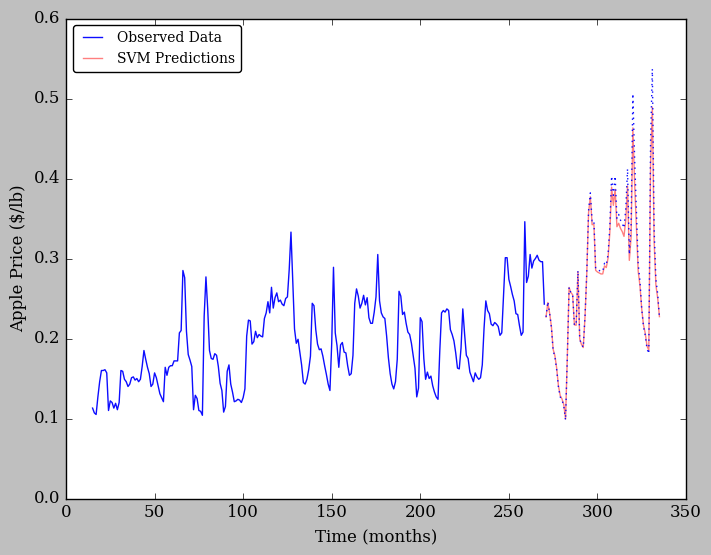

In [31]:
plot(arange(0,len(train_scaledX))+nlags, trainy,'b-', alpha=0.95, label='Observed Data')
plot(arange(0,len(test_scaledX))+size+nlags, clf.predict(test_scaledX),'r-', alpha=0.5, label='SVM Predictions')
plot(arange(0,len(testX))+size+nlags, testy,'b:', alpha=0.95)
plt.legend(fancybox=True, loc=2, prop={'size':10})
xlabel('Time (months)');ylabel('Apple Price ($/lb)') ### prices received by growers 
plt.show()

#### Case 2: What happens when we add less directly-affected predictors?

Now, the same analysis is repeated, except including the additional features.

In [40]:
subset = FullTable[['dates', 'freshprice', 'redprice', 'freshstock', 'frozenstock']]
subset = create_lags(subset,nlags)   ### create N lags
subset = subset.dropna()             ### because we created N lags, the first N rows are now nan's

y = subset.freshprice.values         ### values to predict
X = subset.iloc[:, 1:].values        ### features used in prediction
size = int(len(subset) * .8)         ### 

trainX = X[:size]; trainy = y[:size] ### create 80% training set
testX =  X[size:]; testy = y[size:]  ### create 20% testing set

scaler = pre.StandardScaler().fit(trainX)  ### pre-process and find transformation to put features on similar scales
train_scaledX = scaler.transform(trainX)   ### apply to training set
test_scaledX = scaler.transform(testX)     ### apply to test set

# fit and predict
clf = svm.NuSVR(C=10, gamma=.01)        ### prepare model, set up NuSVR params
clf.fit(train_scaledX, trainy)                         ### set up NuSVR
print 'In-sample accuracy', clf.score(train_scaledX, trainy)   ### find accuracy with training set up NuSVR
for i in arange(10,len(testy),10):                             ### find accuracy with test set
    print 'Out-of-sample accuracy - '+str(i),'predictions out:', clf.score(test_scaledX[0:i], testy[0:i])

In-sample accuracy 0.99996479779
Out-of-sample accuracy - 10 predictions out: 0.947039267573
Out-of-sample accuracy - 20 predictions out: 0.969666564899
Out-of-sample accuracy - 30 predictions out: 0.966501494399
Out-of-sample accuracy - 40 predictions out: 0.934631349294
Out-of-sample accuracy - 50 predictions out: 0.826249940203
Out-of-sample accuracy - 60 predictions out: 0.758215329878


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


While the overall accuracy is comparable, it is interesting to note this model performs worse in predicting average apple prices than the simpler model (a beautiful lesson that more data is not always better). The accuracy drops off faster as we get futher from the training set. This suggests that some of the included features are probably not particularly informative in determining the final prices and implies I clearly should have exercised more discretion in my feature selection.

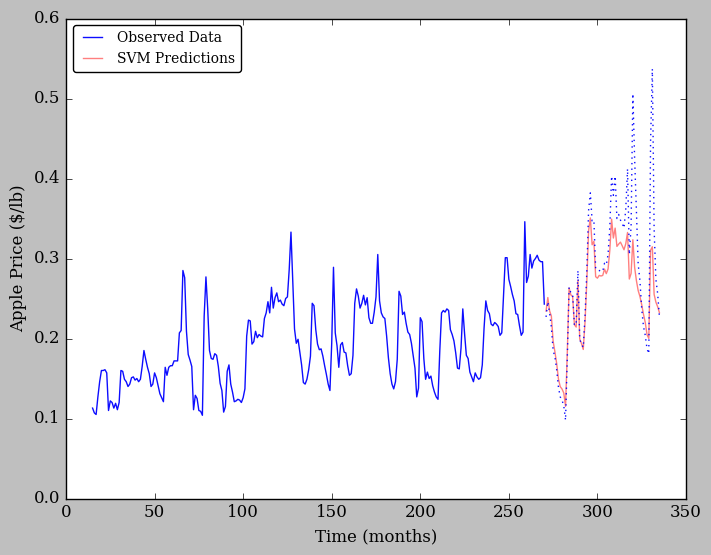

In [41]:
plot(arange(0,len(train_scaledX))+nlags, trainy,'b-', alpha=0.95, label='Observed Data')
plot(arange(0,len(test_scaledX))+size+nlags, clf.predict(test_scaledX),'r-', alpha=0.5, label='SVM Predictions')
plot(arange(0,len(testX))+size+nlags, testy,'b:', alpha=0.95)
plt.legend(fancybox=True, loc=2, prop={'size':10})
xlabel('Time (months)');ylabel('Apple Price ($/lb)') ### prices received by growers 
plt.show()

### 6. The end!

If I find additional time to devote to this little project, I will expand the analysis by:
1. incorporating additional data on apples that is available
2. performing feature selection and model comparison
3. extending the predictions beyond the available 2010 data to the present day to compare performance
4. comparing to other interesting, auxilliary data, such as weather anomalies that could lead to bad seasons and disruptions in expected prices

Now, off to eat a snack.